# Deep Learning Assignment 3 – Marc Glowienke

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

%load_ext jupyternotify
from IPython.display import Audio
sound_file = 'swiftly.mp3'

annots = loadmat('data.mat')
tf.random.set_seed(123)
np.random.seed(123)

<IPython.core.display.Javascript object>

## HYPERPARAMETER COLLECTION

In [2]:
### HYPERPARAMETER COLLECTION
HISTORY = 100
TARGET_LENGTH = 0
SINGLE_STEP = True
BUFFER_SIZE = 1
BATCH_SIZE = 256
EPOCHS_CNN = 30
EPOCHS_LSTM = 20
EPOCHS_CNNLSTM = 10
VAL_PART = 0.15
KERNEL_SIZE = 2

## Data wrangling

In [3]:
df = annots['X']
print(df.shape)
#Shape is time steps X Cities X Features
# 4 Cities, 5 Features

(70128, 4, 5)


Plot of target variable

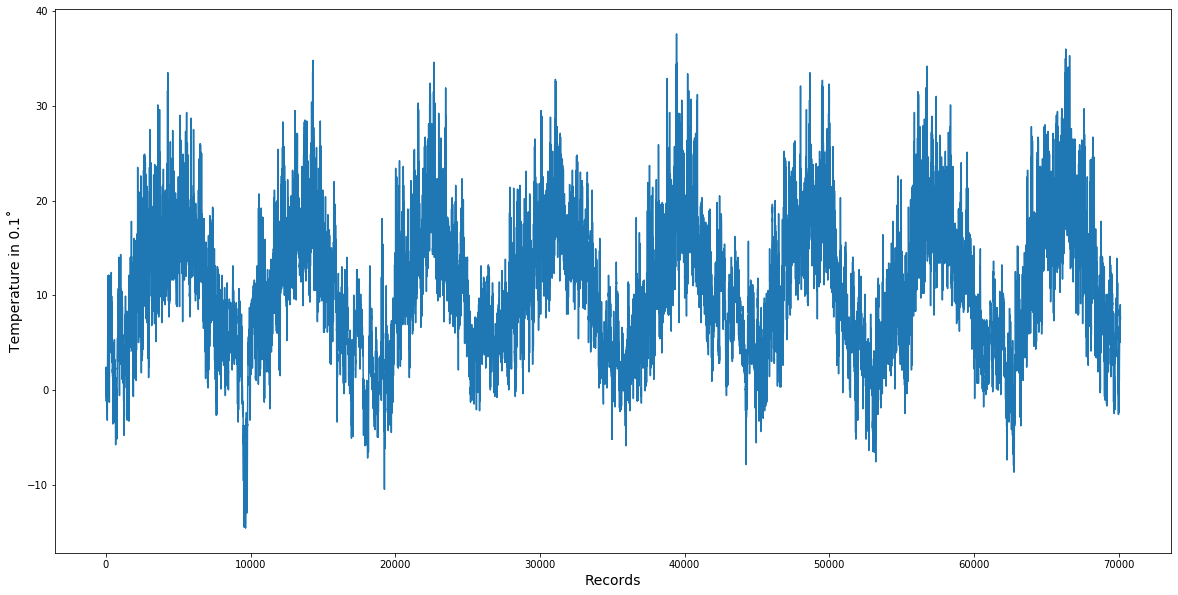

In [4]:
plt.figure(figsize=(20,10))
plt.plot(df[:,3,2]/10)
plt.xlabel("Records",fontsize = 14)
plt.ylabel("Temperature in 0.1˚",fontsize = 14)
plt.savefig('Report/series.pdf',bbox_inches = 'tight')
plt.show()

In [5]:
df_scaled = np.empty(df.shape)
scaler = {}
for feature in range(df.shape[2]):
    scaler[feature] = MinMaxScaler()
    scaler[feature].fit(df[:,:,feature])
    df_scaled[:,:,feature] = scaler[feature].transform(df[:,:,feature])

In [6]:
for feature in range(df.shape[2]):
    print("Minimum of feature %.0f: " %feature, df_scaled[:,:,feature].min())
    print("Maximum of feature %.0f: " %feature, df_scaled[:,:,feature].max(),"\n")

Minimum of feature 0:  0.0
Maximum of feature 0:  1.0 

Minimum of feature 1:  0.0
Maximum of feature 1:  1.0 

Minimum of feature 2:  0.0
Maximum of feature 2:  1.0 

Minimum of feature 3:  0.0
Maximum of feature 3:  1.0 

Minimum of feature 4:  0.0
Maximum of feature 4:  1.0 



Reshape Dataset to (70128,20)

In [7]:
df_reshaped = np.reshape(df_scaled,(70128,20),order='F')

In [8]:
a = np.arange(20).reshape(4, -1).T
print(a.T)
print("\n",np.reshape(a,20,order='F'))

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]

 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [9]:
def data_labelling3d(df,target,start,end,HISTORY,TARGET_LENGTH,SINGLE_STEP):
    data = []
    labels = []
    
    start = start + HISTORY
    if end is None:
        end = df.shape[0] - TARGET_LENGTH
    
    for i in range(start, end):
        indices = range(i - HISTORY,i)
        data.append(df[indices,:,:])
        
        if SINGLE_STEP:
            labels.append(target[i+TARGET_LENGTH])
        else:
            labels.append(target[i:i+TARGET_LENGTH])
    
    return np.array(data), np.array(labels)

def data_labelling2d(df,target,start,end,HISTORY,TARGET_LENGTH,SINGLE_STEP):
    data = []
    labels = []
    
    start = start + HISTORY
    if end is None:
        end = df.shape[0] - TARGET_LENGTH
    
    for i in range(start, end):
        indices = range(i - HISTORY,i)
        data.append(df[indices,:])
        
        if SINGLE_STEP:
            labels.append(target[i+TARGET_LENGTH])
        else:
            labels.append(target[i:i+TARGET_LENGTH])
    
    return np.array(data), np.array(labels)

In [10]:
x_train_lstm, y_train_lstm = data_labelling2d(df_reshaped,df_reshaped[:,17],0,int(69960*(1-VAL_PART)),
                                  HISTORY,TARGET_LENGTH,SINGLE_STEP)
x_val_lstm, y_val_lstm = data_labelling2d(df_reshaped,df_reshaped[:,17],int(69960*(1-VAL_PART)),69960,
                             HISTORY,TARGET_LENGTH,SINGLE_STEP)

train_data_lstm = tf.data.Dataset.from_tensor_slices((x_train_lstm, y_train_lstm))
train_data_lstm = train_data_lstm.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_lstm = tf.data.Dataset.from_tensor_slices((x_val_lstm, y_val_lstm))
val_data_lstm = val_data_lstm.batch(1)

In [11]:
x_train_cnn, y_train_cnn = data_labelling3d(df_scaled,df_scaled[:,3,2],0,int(69960*(1-VAL_PART)),
                                  HISTORY,TARGET_LENGTH,SINGLE_STEP)
x_val_cnn, y_val_cnn = data_labelling3d(df_scaled,df_scaled[:,3,2],int(69960*(1-VAL_PART)),69960,
                             HISTORY,TARGET_LENGTH,SINGLE_STEP)

train_data_cnn = tf.data.Dataset.from_tensor_slices((x_train_cnn, y_train_cnn))
train_data_cnn = train_data_cnn.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_cnn = tf.data.Dataset.from_tensor_slices((x_val_cnn, y_val_cnn))
val_data_cnn = val_data_cnn.batch(1)

## Build and Train model

LSTM Model

In [12]:
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, activation = 'relu', input_shape=x_train_lstm.shape[1:],return_sequences = True),
    tf.keras.layers.LSTM(32, activation = 'relu', return_sequences = True),
    tf.keras.layers.LSTM(16, activation = 'relu', return_sequences = True),
    tf.keras.layers.LSTM(8, activation = 'relu'),
    tf.keras.layers.Dense(1)
    ])

model_lstm.compile(optimizer='sgd', loss='mae')

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           21760     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 32)           12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 16)           3136      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 38,121
Trainable params: 38,121
Non-trainable params: 0
_________________________________________________________________


In [13]:
history_lstm = None
#history_lstm = model_lstm.fit(train_data_lstm, epochs=EPOCHS_LSTM, steps_per_epoch=int(np.ceil(x_train_lstm.shape[0]/BATCH_SIZE)), validation_data = val_data_lstm, validation_steps = 50)

CNN Model

In [14]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', input_shape=x_train_cnn.shape[-3:]),
    tf.keras.layers.MaxPooling2D(pool_size=(KERNEL_SIZE,KERNEL_SIZE)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50,activation = 'relu'),
    tf.keras.layers.Dense(1),   
])

model_cnn.compile(optimizer='adam', loss='mse',metrics = ['mae'])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 3, 64)         1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 1, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                156850    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 158,245
Trainable params: 158,245
Non-trainable params: 0
_________________________________________________________________


In [15]:
history_cnn = None
history_cnn = model_cnn.fit(train_data_cnn, epochs=EPOCHS_CNN, steps_per_epoch=int(np.ceil(x_train_cnn.shape[0]/BATCH_SIZE)),validation_data = val_data_cnn, validation_steps = 50)


Train for 232 steps, validate for 50 steps
Epoch 1/30
232/232 [==============================] - 18s 77ms/step - loss: 0.0088 - mae: 0.0654 - val_loss: 0.0049 - val_mae: 0.0574
Epoch 2/30
232/232 [==============================] - 16s 68ms/step - loss: 0.0042 - mae: 0.0513 - val_loss: 0.0023 - val_mae: 0.0369
Epoch 3/30
232/232 [==============================] - 15s 65ms/step - loss: 0.0037 - mae: 0.0480 - val_loss: 0.0025 - val_mae: 0.0412
Epoch 4/30
232/232 [==============================] - 15s 65ms/step - loss: 0.0039 - mae: 0.0491 - val_loss: 0.0031 - val_mae: 0.0458
Epoch 5/30
232/232 [==============================] - 14s 59ms/step - loss: 0.0046 - mae: 0.0536 - val_loss: 0.0023 - val_mae: 0.0373
Epoch 6/30
232/232 [==============================] - 17s 72ms/step - loss: 0.0055 - mae: 0.0589 - val_loss: 0.0064 - val_mae: 0.0721
Epoch 7/30
232/232 [==============================] - 17s 73ms/step - loss: 0.0088 - mae: 0.0740 - val_loss: 0.0037 - val_mae: 0.0493
Epoch 8/30
232/232 

CNN LSTM Model

In [16]:
model_cnnlstm = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
                                    input_shape=x_train_cnn.shape[-3:]),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_cnnlstm.compile(optimizer='adam', loss='mse')

model_cnnlstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 100, 4, 64)        384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 2, 64)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 36,235
Trainable params: 36,235
Non-trainable params: 0
_________________________________________________________________


In [17]:
history_cnnlstm = None
#history_cnnlstm = model_cnnlstm.fit(train_data_cnn, epochs=EPOCHS_CNNLSTM, steps_per_epoch=int(np.ceil(x_train_cnn.shape[0]/BATCH_SIZE)),validation_data = val_data_cnn, validation_steps = 50)


Plot of Loss Evolution

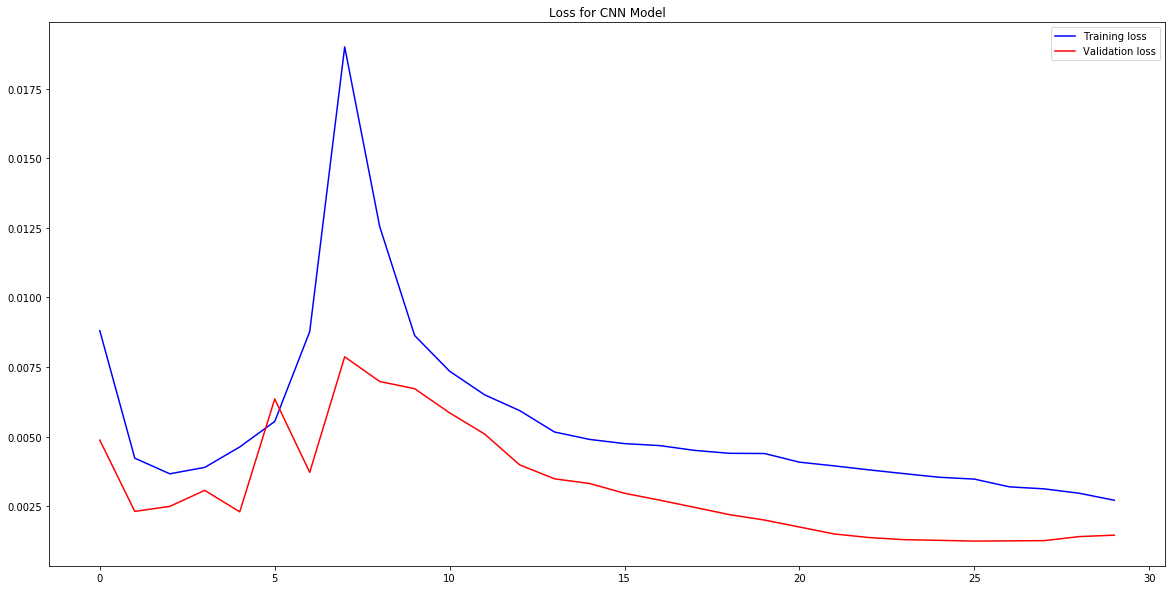

In [18]:
if history_cnn != None:
    loss = history_cnn.history['loss']
    val_loss = history_cnn.history['val_loss']
    plt.figure(figsize= (20,10))
    plt.plot(range(len(loss)), loss, 'b', label='Training loss')
    plt.plot(range(len(loss)), val_loss, 'r', label='Validation loss')
    plt.legend()
    plt.title("Loss for CNN Model")
    #plt.savefig('loss.pdf',bbox_inches = 'tight')
    plt.show()
if history_lstm != None:
    loss = history_lstm.history['loss']
    val_loss = history_lstm.history['val_loss']
    plt.figure(figsize= (20,10))
    plt.plot(range(len(loss)), loss, 'b', label='Training loss')
    plt.plot(range(len(loss)), val_loss, 'r', label='Validation loss')
    plt.legend()
    plt.title("Loss for LSTM Model")
    #plt.savefig('loss.pdf',bbox_inches = 'tight')
    plt.show()
if history_cnnlstm != None:
    loss = history_cnnlstm.history['loss']
    val_loss = history_cnnlstm.history['val_loss']
    plt.figure(figsize= (20,10))
    plt.plot(range(len(loss)), loss, 'b', label='Training loss')
    plt.plot(range(len(loss)), val_loss, 'r', label='Validation loss')
    plt.legend()
    plt.title("Loss for CNN-LSTM Model")
    #plt.savefig('loss.pdf',bbox_inches = 'tight')
    plt.show()


## Prediction for validation set

100%|██████████| 10494/10494 [07:35<00:00, 23.05it/s] 


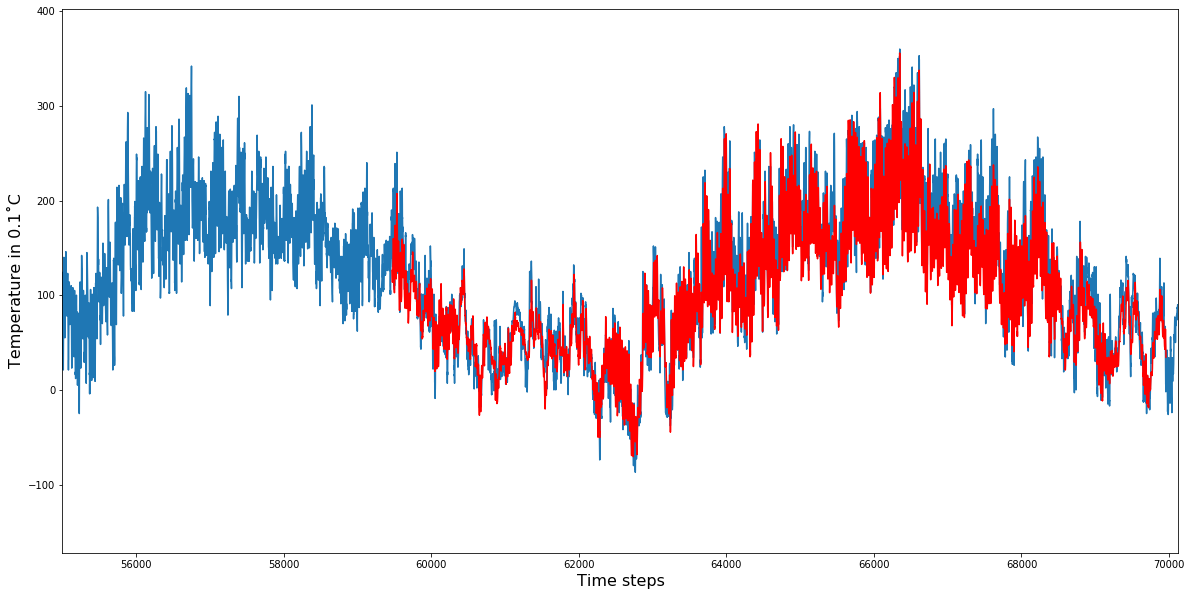

Mean Absolute Error of prediction on validation set: 20.3563


In [19]:
if history_cnn != None: 
    steps = 69960 - int(69960*(1-VAL_PART))
    # Make dataset to start prediction from, i.e. HISTORY last steps of series
    x_predict = np.array(df_scaled[(int(69960*(1-VAL_PART))-HISTORY):int(69960*(1-VAL_PART)),:,:])
    x_predict = np.reshape(x_predict,(1,HISTORY,4,5))

    # Create steps predictions, by adding new prediction to x_predict and deleting the first one
    prediction = np.empty((0,steps))
    for iteration in tqdm(range(steps)):
        y_hat = model_cnn.predict(x_predict,batch_size = 1)
        prediction = np.append(prediction, y_hat)

        x_predict = x_predict[:,1:,:,:] #delete first element

        x_predict = np.append(x_predict,df_scaled[(int(69960*(1-VAL_PART))+iteration),:,:].reshape(1,1,4,5),axis = 1)
                    #add new element
        x_predict[:,-1,3,2] = y_hat #replace temperature for last city with recursive prediction

    # Rescale data
    prediction = prediction.reshape(-1,1)
    prediction_merge = np.concatenate((prediction,prediction,prediction,prediction),axis=1)
    prediction_y = scaler[2].inverse_transform(prediction_merge)[:,0]

    result = np.array([np.array(range(int(69960*(1-VAL_PART)),steps+int(69960*(1-VAL_PART))),dtype='int32')
                           ,prediction_y])
    # Create plot
    plt.figure(figsize=(20,10))
    plt.plot(df[:,3,2])
    plt.plot(result[0],result[1],color='r')
    plt.xlim(55000,70128)
    plt.xlabel("Time steps",fontsize = 16)
    plt.ylabel("Temperature in 0.1˚C",fontsize = 16)
    plt.savefig('Model_CNN.pdf',bbox_inches = 'tight')
    plt.show()
    
        # Calculate MAE
    mae = (np.abs(result[1,:] - df[int(69960*(1-VAL_PART)):69960,3,2]).mean())
    print("Mean Absolute Error of prediction on validation set: %.4f" %mae)

In [20]:
if history_lstm != None: 
    steps = 69960 - int(69960*(1-VAL_PART))
    # Make dataset to start prediction from, i.e. HISTORY last steps of series
    x_predict = np.array(df_reshaped[(int(69960*(1-VAL_PART))-HISTORY):int(69960*(1-VAL_PART)),:])
    x_predict = np.reshape(x_predict,(1,HISTORY,20))

    # Create steps predictions, by adding new prediction to x_predict and deleting the first one
    prediction = np.empty((0,steps))
    for iteration in tqdm(range(steps)):
        y_hat = model_lstm.predict(x_predict,batch_size = 1)
        prediction = np.append(prediction, y_hat)

        x_predict = x_predict[:,1:,:] #delete first element
        x_predict = np.append(x_predict,df_reshaped[(int(69960*(1-VAL_PART))+iteration),:].reshape(1,1,20),axis = 1)
                            #add new element
        x_predict[:,-1,17] = y_hat #replace temperature for last city with recursive prediction


    # Rescale data
    prediction = prediction.reshape(-1,1)
    prediction_merge = np.concatenate((prediction,prediction,prediction,prediction),axis=1)
    prediction_y = scaler[2].inverse_transform(prediction_merge)[:,0]

    result = np.array([np.array(range(int(69960*(1-VAL_PART)),steps+int(69960*(1-VAL_PART))),dtype='int32')
                           ,prediction_y])
    # Create plot
    plt.figure(figsize=(20,10))
    plt.plot(df[:,3,2])
    plt.plot(result[0],result[1],color='r')
    plt.xlim(55000,70128)
    plt.show()
    
    # Calculate MAE
    mae = (np.abs(result[1,:] - df[int(69960*(1-VAL_PART)):69960,3,2]).mean())
    print("Mean Absolute Error of prediction on validation set: %.4f" %mae)

In [21]:
if history_cnnlstm != None: 
    steps = 69960 - int(69960*(1-VAL_PART))
    # Make dataset to start prediction from, i.e. HISTORY last steps of series
    x_predict = np.array(df_scaled[(int(69960*(1-VAL_PART))-HISTORY):int(69960*(1-VAL_PART)),:,:])
    x_predict = np.reshape(x_predict,(1,HISTORY,4,5))

    # Create steps predictions, by adding new prediction to x_predict and deleting the first one
    prediction = np.empty((0,steps))
    for iteration in tqdm(range(steps)):
        y_hat = model_cnnlstm.predict(x_predict,batch_size = 1)
        prediction = np.append(prediction, y_hat)

        x_predict = x_predict[:,1:,:,:] #delete first element

        x_predict = np.append(x_predict,df_scaled[(int(69960*(1-VAL_PART))+iteration),:,:].reshape(1,1,4,5),axis = 1)
                    #add new element
        x_predict[:,-1,3,2] = y_hat #replace temperature for last city with recursive prediction

    # Rescale data
    prediction = prediction.reshape(-1,1)
    prediction_merge = np.concatenate((prediction,prediction,prediction,prediction),axis=1)
    prediction_y = scaler[2].inverse_transform(prediction_merge)[:,0]

    result = np.array([np.array(range(int(69960*(1-VAL_PART)),steps+int(69960*(1-VAL_PART))),dtype='int32')
                           ,prediction_y])
    # Create plot 
    plt.figure(figsize=(20,10))
    plt.plot(df[:,3,2])
    plt.plot(result[0],result[1],color='r')
    plt.xlim(55000,70128)
    plt.xlabel("Time steps",fontsize = 16)
    plt.ylabel("Temperature in 0.1˚C",fontsize = 16)
    plt.savefig('Model_CNNLSTM.pdf',bbox_inches = 'tight')
    plt.show()
    
        # Calculate MAE
    mae = (np.abs(result[1,:] - df[int(69960*(1-VAL_PART)):69960,3,2]).mean())
    print("Mean Absolute Error of prediction on validation set: %.4f" %mae)

## Prediction for test set

100%|██████████| 168/168 [00:05<00:00, 29.15it/s]


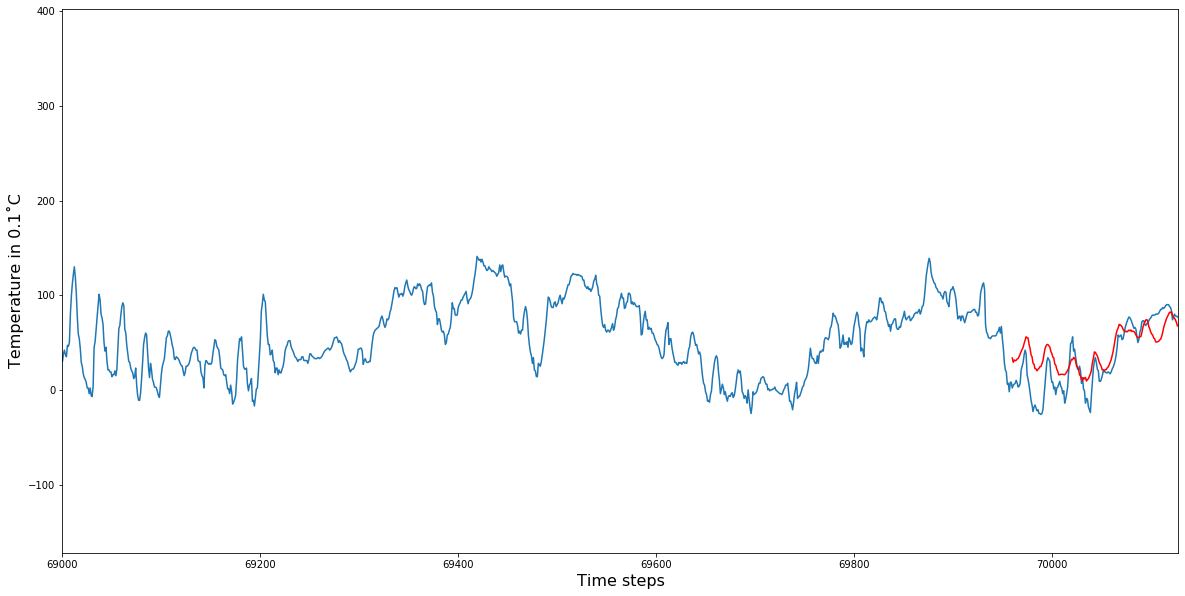

Mean Absolute Error of prediction on test set: 18.1310


In [22]:
if history_cnn != None: 
    steps = 70128 - 69960
    # Make dataset to start prediction from, i.e. HISTORY last steps of series
    x_predict = np.array(df_scaled[(69960-HISTORY):69960,:,:])
    x_predict = np.reshape(x_predict,(1,HISTORY,4,5))

    # Create steps predictions, by adding new prediction to x_predict and deleting the first one
    prediction = np.empty((0,steps))
    for iteration in tqdm(range(steps)):
        y_hat = model_cnn.predict(x_predict,batch_size = 1)
        prediction = np.append(prediction, y_hat)

        x_predict = x_predict[:,1:,:,:] #delete first element

        x_predict = np.append(x_predict,df_scaled[(69960+iteration),:,:].reshape(1,1,4,5),axis = 1)
                    #add new element
        x_predict[:,-1,3,2] = y_hat #replace temperature for last city with recursive prediction

    # Rescale data
    prediction = prediction.reshape(-1,1)
    prediction_merge = np.concatenate((prediction,prediction,prediction,prediction),axis=1)
    prediction_y = scaler[2].inverse_transform(prediction_merge)[:,0]

    result = np.array([np.array(range(69960,70128),dtype='int32')
                           ,prediction_y])
    # Create plot
    plt.figure(figsize=(20,10))
    plt.plot(df[:,3,2])
    plt.plot(result[0],result[1],color='r')
    plt.xlim(69000,70128)
    plt.xlabel("Time steps",fontsize = 16)
    plt.ylabel("Temperature in 0.1˚C",fontsize = 16)
    plt.savefig('Model_CNN_test.pdf',bbox_inches = 'tight')
    plt.show()
    
        # Calculate MAE
    mae = (np.abs(result[1,:] - df[69960:70128,3,2]).mean())
    print("Mean Absolute Error of prediction on test set: %.4f" %mae)

In [23]:
if history_lstm != None: 
    steps = 70128 - 69960
    # Make dataset to start prediction from, i.e. HISTORY last steps of series
    x_predict = np.array(df_reshaped[(69960-HISTORY):69960,:])
    x_predict = np.reshape(x_predict,(1,HISTORY,20))

    # Create steps predictions, by adding new prediction to x_predict and deleting the first one
    prediction = np.empty((0,steps))
    for iteration in tqdm(range(steps)):
        y_hat = model_lstm.predict(x_predict,batch_size = 1)
        prediction = np.append(prediction, y_hat)

        x_predict = x_predict[:,1:,:] #delete first element
        x_predict = np.append(x_predict,df_reshaped[(69960+iteration),:].reshape(1,1,20),axis = 1)
                            #add new element
        x_predict[:,-1,17] = y_hat #replace temperature for last city with recursive prediction


    # Rescale data
    prediction = prediction.reshape(-1,1)
    prediction_merge = np.concatenate((prediction,prediction,prediction,prediction),axis=1)
    prediction_y = scaler[2].inverse_transform(prediction_merge)[:,0]

    result = np.array([np.array(range(69960,70128),dtype='int32')
                           ,prediction_y])
    # Create plot
    plt.figure(figsize=(20,10))
    plt.plot(df[:,3,2])
    plt.plot(result[0],result[1],color='r')
    plt.xlim(69000,70128)
    plt.show()
    
    # Calculate MAE
    mae = (np.abs(result[1,:] - df[69960:70128,3,2]).mean())
    print("Mean Absolute Error of prediction on test set: %.4f" %mae)

In [24]:
if history_cnnlstm != None: 
    steps = 70128 - 69960
    # Make dataset to start prediction from, i.e. HISTORY last steps of series
    x_predict = np.array(df_scaled[(69960-HISTORY):69960,:,:])
    x_predict = np.reshape(x_predict,(1,HISTORY,4,5))

    # Create steps predictions, by adding new prediction to x_predict and deleting the first one
    prediction = np.empty((0,steps))
    for iteration in tqdm(range(steps)):
        y_hat = model_cnnlstm.predict(x_predict,batch_size = 1)
        prediction = np.append(prediction, y_hat)

        x_predict = x_predict[:,1:,:,:] #delete first element

        x_predict = np.append(x_predict,df_scaled[(69960+iteration),:,:].reshape(1,1,4,5),axis = 1)
                    #add new element
        x_predict[:,-1,3,2] = y_hat #replace temperature for last city with recursive prediction

    # Rescale data
    prediction = prediction.reshape(-1,1)
    prediction_merge = np.concatenate((prediction,prediction,prediction,prediction),axis=1)
    prediction_y = scaler[2].inverse_transform(prediction_merge)[:,0]

    result = np.array([np.array(range(69960,70128),dtype='int32')
                           ,prediction_y])
    # Create plot
    plt.figure(figsize=(20,10))
    plt.plot(df[:,3,2])
    plt.plot(result[0],result[1],color='r')
    plt.xlim(69000,70128)
    plt.show()
    
        # Calculate MAE
    mae = (np.abs(result[1,:] - df[69960:70128,3,2]).mean())
    print("Mean Absolute Error of prediction on test set: %.4f" %mae)

In [25]:
%%notify
import time
time.sleep(1)
Audio(sound_file, autoplay=True)

<IPython.core.display.Javascript object>